In [244]:
#Importar librerias
import pandas as pd
import numpy as np 
from datetime import datetime, date
import seaborn as sns
import matplotlib.pyplot as plt
import ast
import holidays
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.cluster import KMeans
from unidecode import unidecode
import re
import warnings

# Ignore FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

In [245]:
#Establecer estilo de los graficos
sns.set(style="darkgrid", palette="Set2",)

# Ignorar advertencias de tipo FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)

In [246]:
#Importacion del dataset
df = pd.read_excel('registros_autos_entrenamiento.xlsx')
df.head()

,Fecha,Unidades
0,2012-01-01,0
1,2012-01-02,188
2,2012-01-03,482
3,2012-01-04,927
4,2012-01-05,1159


In [247]:
df.shape

(2192, 2)

In [248]:
df.isnull().sum()

Fecha       0
Unidades    0
dtype: int64

In [249]:
df[df.duplicated()]

,Fecha,Unidades


In [250]:
df.dtypes

Fecha       datetime64[ns]
Unidades             int64
dtype: object

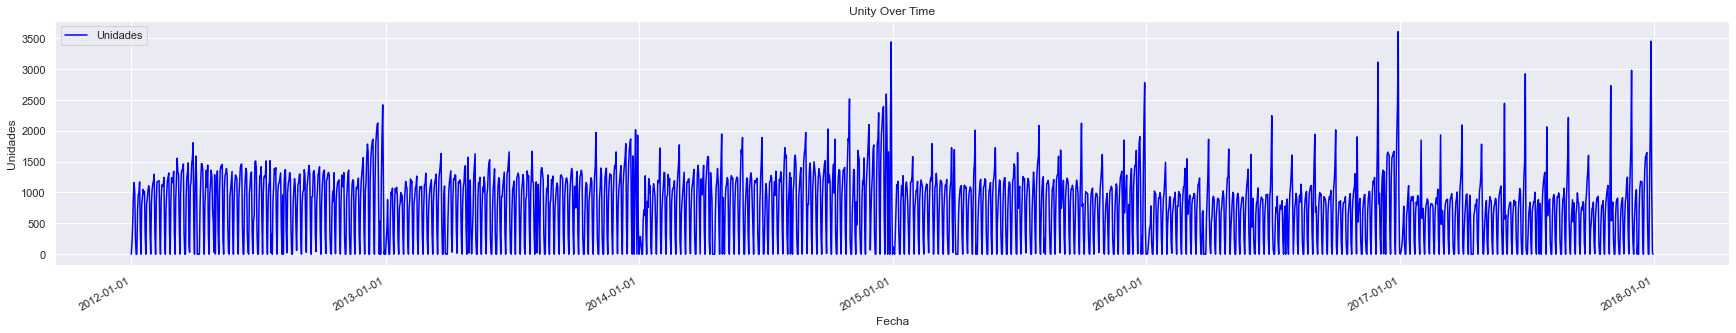

In [251]:
x=np.array(df['Fecha'])
y=np.array(df['Unidades'])
plt.figure(figsize=(30, 5))  # Optional: Set the figure size
plt.plot(x, y, marker=None, linestyle='-', color='b', label='Unidades')

# Optional: Add labels and title
plt.xlabel('Fecha')
plt.ylabel('Unidades')
plt.title('Unity Over Time')

# Optional: Customize the x-axis date formatting
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()  # Rotates and formats the x-axis dates for better readability

# Optional: Add a legend
plt.legend()

# Show the plot
plt.show()

In [252]:
df['Unidades'].describe()

count    2192.000000
mean      782.165602
std       551.164725
min         0.000000
25%       293.000000
50%       865.500000
75%      1173.000000
max      3603.000000
Name: Unidades, dtype: float64

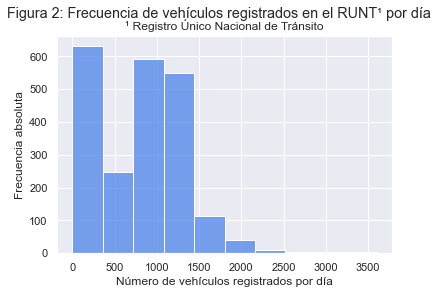

In [253]:
sns.histplot(data=df, x='Unidades', bins=10, color='#4d85ea')
plt.title("¹ Registro Único Nacional de Tránsito")
plt.xlabel("Número de vehículos registrados por día")
plt.ylabel("Frecuencia absoluta")
plt.suptitle("Figura 2: Frecuencia de vehículos registrados en el RUNT¹ por día")
plt.show()

In [254]:
df['Dia'] = df['Fecha'].dt.day
df['Mes'] = df['Fecha'].dt.month
df['Año'] = df['Fecha'].dt.year

In [255]:
df.head(-10)

,Fecha,Unidades,Dia,Mes,Año
0,2012-01-01,0,1,1,2012
1,2012-01-02,188,2,1,2012
2,2012-01-03,482,3,1,2012
3,2012-01-04,927,4,1,2012
4,2012-01-05,1159,5,1,2012
...,...,...,...,...,...
2177,2017-12-17,0,17,12,2017
2178,2017-12-18,959,18,12,2017
2179,2017-12-19,1364,19,12,2017
2180,2017-12-20,1577,20,12,2017


In [256]:

festivos = holidays.country_holidays('CO', years=[2012, 2013, 2014, 2015, 2016, 2017])
def es_festivo(fecha):
    return 1 if fecha.date() in festivos else 0

# Crear la columna 'Festivo' en función de la función es_festivo
df['Festivo'] = df['Fecha'].apply(es_festivo).astype('boolean')
df['Dia_Semana'] = df['Fecha'].dt.dayofweek
df['Semana_Año'] = df['Fecha'].dt.isocalendar().week

def determinar_quincena(fecha):
    return np.where(fecha.dt.day <= 15, 1, 2)
df['Quincena'] = determinar_quincena(df['Fecha'])



In [257]:
condicion_dias_laborales = (df['Dia_Semana'] != 6) & (df['Festivo'] != 1)
df['dias_laborales'] = condicion_dias_laborales.astype(int)

In [258]:
print(df)

          Fecha  Unidades  Dia  Mes   Año  Festivo  Dia_Semana  Semana_Año  \
0    2012-01-01         0    1    1  2012     True           6          52   
1    2012-01-02       188    2    1  2012    False           0           1   
2    2012-01-03       482    3    1  2012    False           1           1   
3    2012-01-04       927    4    1  2012    False           2           1   
4    2012-01-05      1159    5    1  2012    False           3           1   
...         ...       ...  ...  ...   ...      ...         ...         ...   
2187 2017-12-27      2102   27   12  2017    False           2          52   
2188 2017-12-28      3449   28   12  2017    False           3          52   
2189 2017-12-29      1084   29   12  2017    False           4          52   
2190 2017-12-30        18   30   12  2017    False           5          52   
2191 2017-12-31         0   31   12  2017    False           6          52   

      Quincena  dias_laborales  
0            1               0

In [259]:
trm = pd.read_excel('TRM.xlsx')
trm.head()

,Fecha,TRM
0,2012-01-01,1942.70
1,2012-01-02,1942.70
2,2012-01-03,1942.70
3,2012-01-04,1915.02
4,2012-01-05,1898.24


In [260]:
data=pd.merge(df, trm, on='Fecha', how='left')
data.head()

,Fecha,Unidades,Dia,Mes,Año,Festivo,Dia_Semana,Semana_Año,Quincena,dias_laborales,TRM
0,2012-01-01,0,1,1,2012,True,6,52,1,0,1942.70
1,2012-01-02,188,2,1,2012,False,0,1,1,1,1942.70
2,2012-01-03,482,3,1,2012,False,1,1,1,1,1942.70
3,2012-01-04,927,4,1,2012,False,2,1,1,1,1915.02
4,2012-01-05,1159,5,1,2012,False,3,1,1,1,1898.24


In [261]:
data2017=data[data['Año'] ==2017]
data=data[data['Año'] < 2017]

In [262]:
data.dtypes

Fecha             datetime64[ns]
Unidades                   int64
Dia                        int32
Mes                        int32
Año                        int32
Festivo                  boolean
Dia_Semana                 int32
Semana_Año                UInt32
Quincena                   int32
dias_laborales             int32
TRM                      float64
dtype: object

In [263]:
data.head()

,Fecha,Unidades,Dia,Mes,Año,Festivo,Dia_Semana,Semana_Año,Quincena,dias_laborales,TRM
0,2012-01-01,0,1,1,2012,True,6,52,1,0,1942.70
1,2012-01-02,188,2,1,2012,False,0,1,1,1,1942.70
2,2012-01-03,482,3,1,2012,False,1,1,1,1,1942.70
3,2012-01-04,927,4,1,2012,False,2,1,1,1,1915.02
4,2012-01-05,1159,5,1,2012,False,3,1,1,1,1898.24


In [274]:
columnas_seleccionadas = ['Dia','Mes','Año', 'Festivo','Dia_Semana','dias_laborales','Quincena']
datanew=data[columnas_seleccionadas]

Mean Squared Error (MSE): 104116.76864565563
R^2 Score: 0.6471261607509486
Mean Absolute Error (MAE): 253.94176247726523


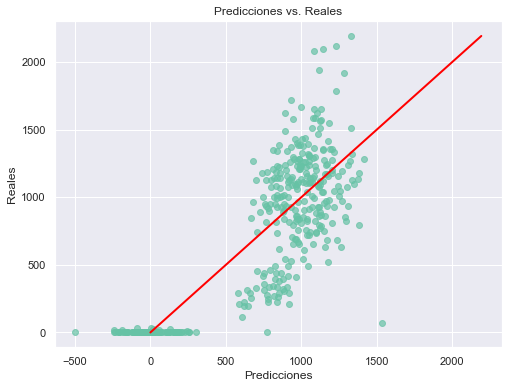

In [275]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

# Supongamos que 'data' es tu DataFrame con columnas 'feature' y 'target'
# Asegúrate de tener tus datos limpios y de haber tratado los valores nulos

# Dividir el conjunto de datos en características (X) y variable objetivo (y)
X = datanew
y = data['Unidades']

# Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear un modelo de regresión lineal
modellr = LinearRegression()

# Entrenar el modelo con el conjunto de entrenamiento
modellr.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = modellr.predict(X_test)

# Evaluar el rendimiento del modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'R^2 Score: {r2}')
print(f'Mean Absolute Error (MAE): {mae}')

# Visualizar el modelo
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, y_test, alpha=0.7)
plt.xlabel("Predicciones")
plt.ylabel("Reales")
plt.title("Predicciones vs. Reales")

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linewidth=2)


Mean Squared Error (MSE): 18819.792567079287
R^2 Score: 0.936215726406016
Mean Absolute Error (MAE): 87.90174082747853


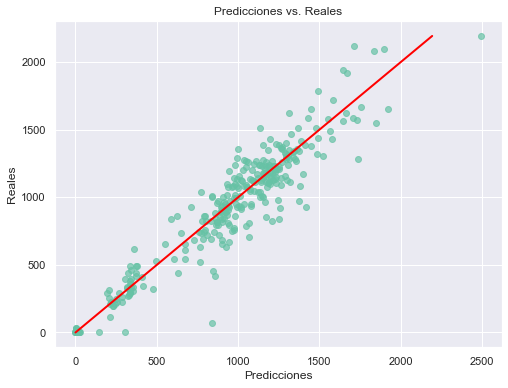

In [276]:

from sklearn.ensemble import RandomForestRegressor
from xgboost import plot_importance
X = datanew
y = data['Unidades']

# Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear un modelo de regresión de bosques aleatorios
modelrf = RandomForestRegressor(random_state=42,n_estimators=350)

# Entrenar el modelo con el conjunto de entrenamiento
modelrf.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = modelrf.predict(X_test)

# Evaluar el rendimiento del modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'R^2 Score: {r2}')
print(f'Mean Absolute Error (MAE): {mae}')

# Visualizar el modelo
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, y_test, alpha=0.7)
plt.xlabel("Predicciones")
plt.ylabel("Reales")
plt.title("Predicciones vs. Reales")

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linewidth=2)
plt.show()



Mean Squared Error (MSE): 47726.59986617598
R^2 Score: 0.8382444177998074
Mean Absolute Error (MAE): 145.77985948477752


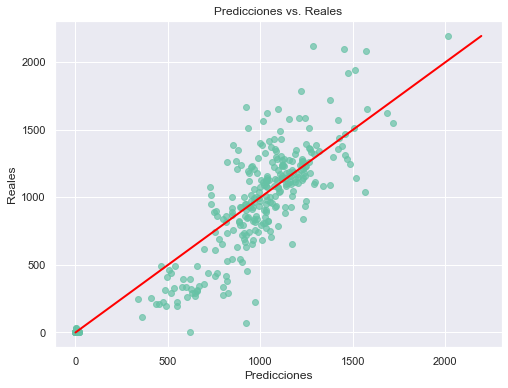

In [277]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

# Supongamos que ya tienes tus datos X e y

# Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Aplicar preprocesamiento (escalar las características)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Crear un modelo de regresión KNN
knn_model = KNeighborsRegressor(n_neighbors=7)  # Puedes ajustar el valor de 'n_neighbors'

# Entrenar el modelo con el conjunto de entrenamiento escalado
knn_model.fit(X_train_scaled, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = knn_model.predict(X_test_scaled)

# Evaluar el rendimiento del modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'R^2 Score: {r2}')
print(f'Mean Absolute Error (MAE): {mae}')

# Visualizar el modelo
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, y_test, alpha=0.7)
plt.xlabel("Predicciones")
plt.ylabel("Reales")
plt.title("Predicciones vs. Reales")

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linewidth=2)
plt.show()


Mean Squared Error (MSE): 17497.62150676594
R^2 Score: 0.9406968449065779
Mean Absolute Error (MAE): 94.83997279373023


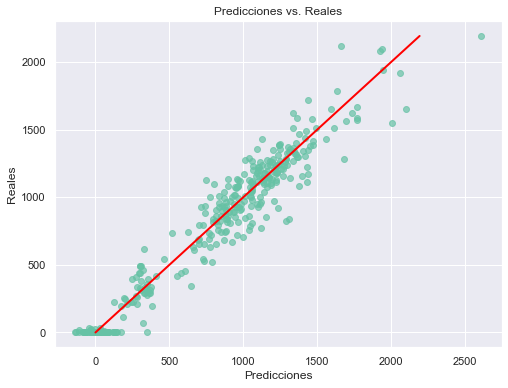

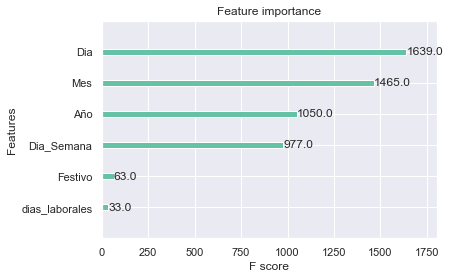

In [278]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

# Supongamos que ya tienes tus datos X e y

# Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear un modelo de regresión XGBoost
modelxgb = XGBRegressor(random_state=42)

# Entrenar el modelo con el conjunto de entrenamiento
modelxgb.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = modelxgb.predict(X_test)

# Evaluar el rendimiento del modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'R^2 Score: {r2}')
print(f'Mean Absolute Error (MAE): {mae}')

# Visualizar el modelo
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, y_test, alpha=0.7)
plt.xlabel("Predicciones")
plt.ylabel("Reales")
plt.title("Predicciones vs. Reales")

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linewidth=2)
plt.show()

plot_importance(modelxgb)
plt.show()


In [269]:
trm18 = pd.read_excel('TRM18.xlsx')
trm18.head()

,Fecha,TRM
0,2018-01-01,2984.00
1,2018-01-02,2984.00
2,2018-01-03,2940.94
3,2018-01-04,2908.68
4,2018-01-05,2885.76


In [270]:
start_date = datetime(2018, 1, 1)
end_date = datetime(2018, 12, 31)

# Crear un rango de fechas
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Crear un DataFrame con las fechas
df2018 = pd.DataFrame(date_range, columns=['Fecha'])
df2018['Dia'] = df2018['Fecha'].dt.day
df2018['Mes'] = df2018['Fecha'].dt.month
df2018['Año'] = df2018['Fecha'].dt.year
df2018['Festivo'] = df2018['Fecha'].apply(es_festivo)
df2018['Dia_Semana'] = df2018['Fecha'].dt.dayofweek
df2018['Semana_Año'] = df2018['Fecha'].dt.isocalendar().week
condicion_dias_laborales = (df2018['Dia_Semana'] != 6) & (df2018['Festivo'] != 1)
df2018['dias_laborales'] = condicion_dias_laborales.astype(int)

data2018=pd.merge(df2018, trm18, on='Fecha', how='left')
print(data2018)


         Fecha  Dia  Mes   Año  Festivo  Dia_Semana  Semana_Año  \
0   2018-01-01    1    1  2018        1           0           1   
1   2018-01-02    2    1  2018        0           1           1   
2   2018-01-03    3    1  2018        0           2           1   
3   2018-01-04    4    1  2018        0           3           1   
4   2018-01-05    5    1  2018        0           4           1   
..         ...  ...  ...   ...      ...         ...         ...   
360 2018-12-27   27   12  2018        0           3          52   
361 2018-12-28   28   12  2018        0           4          52   
362 2018-12-29   29   12  2018        0           5          52   
363 2018-12-30   30   12  2018        0           6          52   
364 2018-12-31   31   12  2018        0           0           1   

     dias_laborales      TRM  
0                 0  2984.00  
1                 1  2984.00  
2                 1  2940.94  
3                 1  2908.68  
4                 1  2885.76  
..       

In [280]:
data2017x=data2017[columnas_seleccionadas]
data2017y=data2017['Unidades']



In [281]:
data2017x.head()

,Dia,Mes,Año,Festivo,Dia_Semana,dias_laborales,Quincena
1827,1,1,2017,True,6,0,1
1828,2,1,2017,False,0,1,1
1829,3,1,2017,False,1,1,1
1830,4,1,2017,False,2,1,1
1831,5,1,2017,False,3,1,1


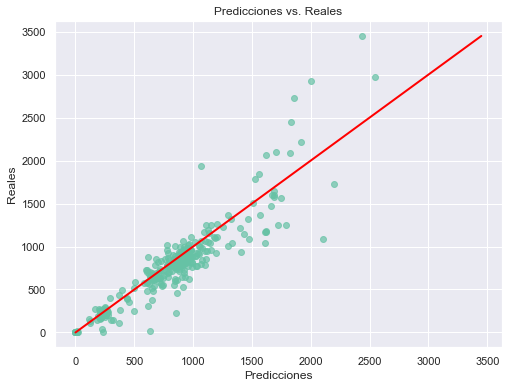

18819.792567079287
34028.019908996364
0.936215726406016
0.8781190476938079
dif =57.554803611982564 y difr2=6.404185108675174


In [286]:
y_pred=modelrf.predict(X_test)
y_pred = np.maximum(0, y_pred)
y_pred2=modelrf.predict(data2017x)
y_pred2= np.maximum(0, y_pred2)
mse1=mean_squared_error(y_test,y_pred)
mse2=mean_squared_error(data2017y,y_pred2)

mae1=mean_absolute_error(y_test,y_pred)
mae2=mean_absolute_error(data2017y,y_pred2)

r2t=r2_score(y_test,y_pred)
r2v=r2_score(data2017y,y_pred2)



dif=abs(mse1-mse2)/((mse1+mse2)/2)*100
difr2=abs(r2t-r2v)/((r2t+r2v)/2)*100

plt.figure(figsize=(8, 6))
plt.scatter(y_pred2, data2017y, alpha=0.7)
plt.xlabel("Predicciones")
plt.ylabel("Reales")
plt.title("Predicciones vs. Reales")

plt.plot([min(data2017y), max(data2017y)], [min(data2017y), max(data2017y)], color="red", linewidth=2)
plt.show()

print(mse1)
print(mse2)

print(r2t)
print(r2v)

print(f'dif ={dif} y difr2={difr2}')